## 1. Préparation
On importe d'abord les librairies qu'il faut.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import dill as pickle

from keras.datasets import mnist
from keras.models import Model
from keras.layers import Dense, Input
from keras import regularizers

from sklearn.manifold import TSNE


from time import time

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1085: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1085: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
from scipy.stats import randint as sp_randint

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

Et le jeu de données pré-traité, avec les variables catégoriques en représentation one-hot.

In [2]:
complete_preprocessed = pd.read_pickle("preprocessed")
complete_preprocessed.head()

,age,capitalGain,capitalLoss,hoursPerWeek,countryProvided,country_typeI,nationals,educationGeneral,workclass_Federal-gov,workclass_Local-gov,...,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,isFemale
0,0.109589,0.000000,0.0,0.397959,1,1,1,0.03125,0,0,...,0,0,1,0,0,0,0,1,0,0
1,0.287671,0.000000,0.0,0.500000,1,1,1,0.06250,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.150685,0.000000,0.0,0.397959,1,1,1,0.12500,0,1,...,0,0,0,0,0,0,0,0,0,0
3,0.369863,0.076881,0.0,0.397959,1,1,1,0.12500,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0.013699,0.000000,0.0,0.295918,1,1,1,0.12500,0,0,...,0,0,1,0,0,0,0,0,0,1


On découpe ensuite le jeu de données en jeu d'entraînement et jeu de test, de façon aléatoire à un taux 8:2.

In [12]:
X = complete_preprocessed[complete_preprocessed.columns.difference(
    ["salary_<=50K", "salary_>50K"])]

y = complete_preprocessed["salary_>50K"]

import sklearn

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

## 2. Algorithmes classiques

Maintenant on peut commmencer avec nos algorithmes. On a envie de voir d'abord deux algorithmes relativement simples à tuner : la régression logistique et la KNN.   

### 2.1 Régression logistique par validation croisée
`scikit-learn` a implémenté une classe très pratique exlusivement pour entraîner la régression logistique par validation croisée en recherche par grille, `LogisticRegressionCV`. Son avantage par rapport à `GridSearchCV`, c'est la vitesse.   
  
On voit dans la suite que la 1ère implémentation est 3 fois plus rapide que la deuxième.

In [5]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.cross_validation import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.grid_search import GridSearchCV


# https://github.com/scikit-learn/scikit-learn/issues/6619
fold_logi = KFold(y_train.shape[0], n_folds=5, shuffle=True, random_state=5490)

logi_searchCV = LogisticRegressionCV(Cs=list(np.power(10.0, np.arange(-10, 10))), 
                                     scoring='accuracy', cv=fold_logi, 
                                     random_state=5490, max_iter=10000,
                                     fit_intercept=True,
                                     solver='newton-cg',
                                     tol=1e-4)
start = time()
logi_searchCV.fit(X_train, y_train)

print ('LogisticRegressionCV took %.2f seconds and the best score is %.2f. ' 
       % (time() - start, logi_searchCV.scores_[1].max()))

    
grid_logi = {'C': np.power(10.0, np.arange(-10, 10)), 'solver': ['newton-cg']}

logi_reg = LogisticRegression(random_state=5490, max_iter=10000, tol=1e-4)
logi_gs = GridSearchCV(logi_reg, grid_logi, scoring='accuracy', cv=fold_logi)
start = time()
logi_gs.fit(X, y)
print ("GridSearchCV took %.2f seconds and the best score is %.2f. "
      % (time() - start, logi_gs.best_score_))



/home/ubuntu/anaconda3/lib/python3.6/site-packages/scipy/optimize/linesearch.py:285: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/utils/optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


LogisticRegressionCV took 13.77 seconds and the best score is 0.85. 


/home/ubuntu/anaconda3/lib/python3.6/site-packages/scipy/optimize/linesearch.py:285: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/utils/optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


GridSearchCV took 39.34 seconds and the best score is 0.85. 


### 2.2 KNN et le choix de k
La méthode KNN est l'une des plus simples à implémenter et à tuner. On voit néanmoins une forte tendance d'augmentation en temps d'exécution lorsque le nombre k monte.


KNN 1
estimations par validation croisée 10 fold de KNN 1 :
Taux biens classés = 0.797 +/- 0.004
Temps d'exécution = 37.230 secondes


KNN 3
estimations par validation croisée 10 fold de KNN 3 :
Taux biens classés = 0.819 +/- 0.006
Temps d'exécution = 41.723 secondes




/home/ubuntu/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


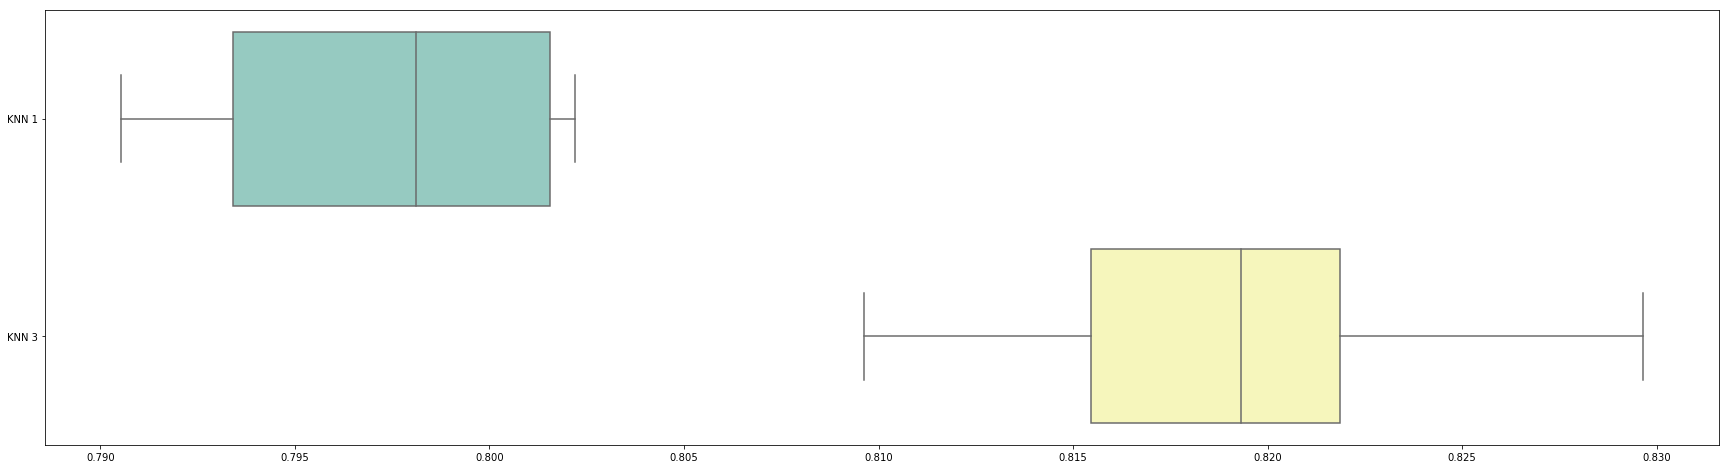

In [12]:
algos = { key:value for key,value in Liste.items() if key in ["KNN 1", "KNN 3"]}

runClassifiers(algos, X, y, graphe = True)

KNN 5
estimations par validation croisée 10 fold de KNN 5 :
Taux biens classés = 0.828 +/- 0.005
Temps d'exécution = 39.860 secondes


KNN 7
estimations par validation croisée 10 fold de KNN 7 :
Taux biens classés = 0.831 +/- 0.006
Temps d'exécution = 51.483 secondes




/home/ubuntu/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


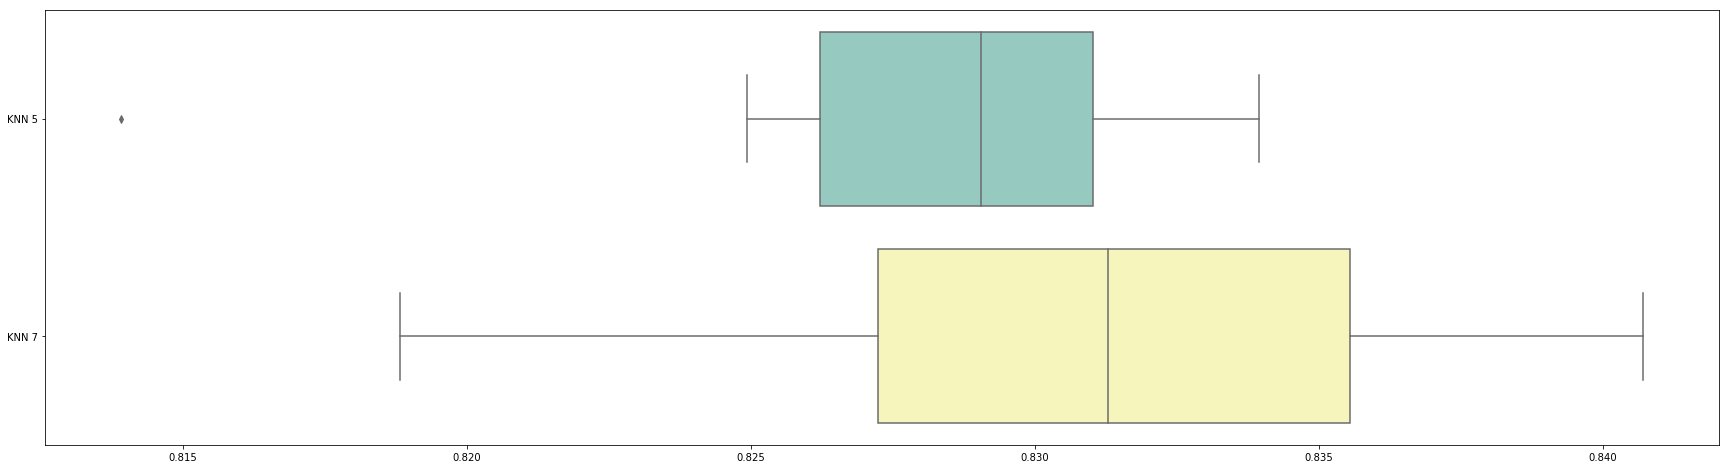

In [13]:
algos = { key:value for key,value in Liste.items() if key in ["KNN 5", "KNN 7"]}
runClassifiers(algos, X, y, graphe = True)

Du coup quel est le meilleur k ? On peut chercher par validation croisée. Ici, on utilise `GridSearchCV`, parce qu'on veut parcourir tous les k possibles. La meilleure valeur de k trouvée est 9 et le taux de bons classement sur le jeu de test est 85,6%.

In [44]:
knn = KNeighborsClassifier(n_jobs = -1)

param_grid_KNN = {"n_neighbors": range(1, 10, 2)}

grid_search_KNN = GridSearchCV(knn, param_grid=param_grid_KNN,
                                    n_jobs = -1)

start = time()
grid_search_KNN.fit(X, y)
print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search_RF_encoded.cv_results_['params'])))
report(grid_search_KNN.cv_results_)

RandomizedSearchCV took 134.33 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.832 (std: 0.002)
Parameters: {'n_neighbors': 9}

Model with rank: 2
Mean validation score: 0.829 (std: 0.003)
Parameters: {'n_neighbors': 7}

Model with rank: 3
Mean validation score: 0.825 (std: 0.004)
Parameters: {'n_neighbors': 5}



In [45]:
grid_search_KNN.best_estimator_.score(X_test, y_test)

0.8561777049851571

## 2.3 Forêt aléatoire et RandomisedSearchCV
Maintenant on s'intéresse à la forêt aléatoire. Etant un algorithme classique mais très robuste et efficace, il a beaucoup d'hyper-paramètres à tuner. Ici, on met l'accent sur la comparaison de deux approches de recherche de la meileure combinaison des hyper-paramètres : `GridSearchCV` et `RandomisedSearchCV`. On verra que la deuxième étant beaucoup plus efficace que la première, sa baisse en qualité de prédiction est juste négligeable. Ici, dans notre exemple concret, même mieux.

In [31]:
RF = RandomForestClassifier(n_jobs = -1)

# use a full grid over all parameters
param_grid_RF = {"max_depth": [None],
              "max_features": [2, "log2", "sqrt"],
              "min_samples_split": [20, 10, 5],
              "min_samples_leaf": [20, 10, 5],
              "bootstrap": [True],
              "criterion": ["gini"],
                        "n_estimators": [20, 50, 100, 200]}

# run grid search
grid_search_RF = GridSearchCV(RF, param_grid=param_grid_RF, n_jobs = -1)
start = time()
grid_search_RF.fit(X_train, y_train)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search_RF.cv_results_['params'])))
report(grid_search_RF.cv_results_)

GridSearchCV took 59.03 seconds for 108 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.865 (std: 0.002)
Parameters: {'bootstrap': True, 'criterion': 'gini', 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 20, 'n_estimators': 100}

Model with rank: 2
Mean validation score: 0.865 (std: 0.002)
Parameters: {'bootstrap': True, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 20, 'n_estimators': 100}

Model with rank: 2
Mean validation score: 0.865 (std: 0.002)
Parameters: {'bootstrap': True, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 200}



In [32]:
grid_search_RF.best_estimator_.score(X_test, y_test)

0.8604770191421844

In [41]:
RF2 = RandomForestClassifier(n_jobs = -1)

# Specify parameters and distributions to sample from
param_dist_RF = {"max_depth": [3, None],
                 "max_features": sp_randint(1, 47),
                 "min_samples_split": sp_randint(2, 11),
                 "min_samples_leaf": sp_randint(1, 11),
                 "bootstrap": [True, False],
                 "criterion": ["gini", "entropy"]}


# Randomized search
n_iter_search = 20
random_search_RF = RandomizedSearchCV(RF2, param_distributions=param_dist_RF,
                                   n_iter=n_iter_search)

start = time()
random_search_RF.fit(X, y)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(random_search_RF.cv_results_)

RandomizedSearchCV took 22.70 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.864 (std: 0.002)
Parameters: {'bootstrap': True, 'criterion': 'gini', 'max_depth': None, 'max_features': 7, 'min_samples_leaf': 5, 'min_samples_split': 4}

Model with rank: 2
Mean validation score: 0.863 (std: 0.001)
Parameters: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': None, 'max_features': 10, 'min_samples_leaf': 6, 'min_samples_split': 7}

Model with rank: 3
Mean validation score: 0.863 (std: 0.002)
Parameters: {'bootstrap': False, 'criterion': 'entropy', 'max_depth': None, 'max_features': 18, 'min_samples_leaf': 10, 'min_samples_split': 2}



In [42]:
random_search_RF.best_estimator_.score(X_test, y_test)

0.8752175248234211

### 2.4 SVM et l'utilité de la recherche des meilleurs hyper-paramètres par RandomisedSearchCV
On aimerait maintenant voir la méthode SVM avec et sans l'approche `RandomisedSearchCV`, tout en sachant que la classe `svc` elle-même, appliquant par défaut la noyau gaussien, fait aussi une recherche automatique de $\gamma$.

In [27]:
from sklearn import svm
svm1 = svm.SVC()
svm1.fit(X_train, y_train)
svm1.score(X_test, y_test)

0.8335551233493704

In [ ]:
from sklearn import svm

param_grid_svm = {"C": [0.5, 1, 2]}

svm2 = svm.SVC()

grid_search_svm = GridSearchCV(svm2, param_grid_svm)
start = time()
grid_search_svm.fit(X_train, y_train)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search_svm.cv_results_['params'])))
report(grid_search_svm.cv_results_)

In [ ]:
import scipy

from sklearn import svm
SVM = svm.SVC()


param_dist_SVM = {"C": scipy.stats.expon(scale=10), 
                  # 'gamma': scipy.stats.expon(scale=.1),
                  'kernel': ['rbf'], 
                  'class_weight': ['balanced']}

# Randomized search
n_iter_search = 4
random_search_SVM = RandomizedSearchCV(SVM, param_distributions=param_dist_SVM,
                                   n_iter=n_iter_search)

start = time()
random_search_SVM.fit(X, y)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(random_search_SVM.cv_results_)

In [13]:
import scipy
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

ada_discrete = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1))

param_dist_adaboost = {"n_estimators": sp_randint(1, 200), 
                       "learning_rate": scipy.stats.expon(scale=10)
                      }

n_iter_search = 40


random_search_adaboost = RandomizedSearchCV(ada_discrete, param_distributions=param_dist_adaboost,
                                   n_iter=n_iter_search)

start = time()
random_search_adaboost.fit(X_train, y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(random_search_adaboost.cv_results_)

RandomizedSearchCV took 193.24 seconds for 40 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.868 (std: 0.004)
Parameters: {'learning_rate': 1.082549439226139, 'n_estimators': 196}

Model with rank: 2
Mean validation score: 0.867 (std: 0.002)
Parameters: {'learning_rate': 1.7526416188941465, 'n_estimators': 140}

Model with rank: 3
Mean validation score: 0.867 (std: 0.005)
Parameters: {'learning_rate': 1.108339728320232, 'n_estimators': 132}



In [14]:
random_search_adaboost.best_estimator_.score(X_test, y_test)

0.8693827413245983

## 3. Prédiction par méthode supervisée précédée d'une réduction de dimensions
Ce jeu de données a 46 variables indépendantes. On veut savoir, si une réduction de dimension précédant la méthode de prédiction (ici, forêt aléatoire) peut améliorer la prédiction. Pour la méthode de réduction, on utilise l'auto-encodeur qui réduit les 48 dimensions à 4. Conclusion : par rapport à la forêt aléatoire qu'on a utilisée avant, la réduction de dimension a même baissé le taux de bons classements. Une rasion c'est que la forêt aléatoire est un algo assez robuste à la haute-dimension.

In [13]:
# compile autoencoder
autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.fit(X, X,
                nb_epoch=20,
                batch_size=20,
                shuffle=True)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  import sys


Epoch 1/20
48842/48842 [==============================] - 3s 70us/step - loss: 0.0533
Epoch 2/20
48842/48842 [==============================] - 3s 66us/step - loss: 0.0328
Epoch 3/20
48842/48842 [==============================] - 3s 67us/step - loss: 0.0284
Epoch 4/20
48842/48842 [==============================] - 3s 67us/step - loss: 0.0271
Epoch 5/20
48842/48842 [==============================] - 3s 68us/step - loss: 0.0266
Epoch 6/20
48842/48842 [==============================] - 3s 67us/step - loss: 0.0261
Epoch 7/20
48842/48842 [==============================] - 3s 67us/step - loss: 0.0256
Epoch 8/20
48842/48842 [==============================] - 3s 66us/step - loss: 0.0252
Epoch 9/20
48842/48842 [==============================] - 3s 67us/step - loss: 0.0250
Epoch 10/20
48842/48842 [==============================] - 3s 66us/step - loss: 0.0250
Epoch 11/20
48842/48842 [==============================] - 3s 67us/step - loss: 0.0249
Epoch 12/20
48842/48842 [===========================

In [16]:
X_encoded = encoder.predict(X, batch_size = 20)
X_encoded.shape

(48842, 4)

In [17]:
X_encoded_train, X_encoded_test, y_encoder_train, y_encoder_test = train_test_split(X_encoded, y, test_size = 0.2)

In [8]:
# build a classifier
RF_encoded = RandomForestClassifier(n_estimators=20, n_jobs = -1)


# use a full grid over all parameters
param_grid_RF_encoded = {"max_depth": [None],
              "max_features": [1, 2],
              "min_samples_split": [10, 20],
              "min_samples_leaf": [10, 20],
              "bootstrap": [True],
              "criterion": ["entropy"]}

# run grid search
grid_search_RF_encoded = GridSearchCV(RF_encoded, param_grid=param_grid_RF_encoded, n_jobs = -1)
start = time()
grid_search_RF_encoded.fit(X_encoded_train, y_encoder_train)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search_RF_encoded.cv_results_['params'])))
report(grid_search_RF_encoded.cv_results_)

NameError: name 'X_encoded_train' is not defined

In [35]:
grid_search_RF_encoded.best_estimator_.score(X_encoded_test, y_encoder_test)

0.8343740403316614

## 4. Un petit résumé : comparaison des algos de base

In [11]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import roc_auc_score, average_precision_score
import time
%matplotlib inline
from matplotlib.ticker import FuncFormatter
import seaborn as sns

def tracePerformancesPercentage(dictionnaire): 
    pass
    
def runClassifiers(clfs, X, Y, graphe = True) :
    kf = KFold(n_splits=10, shuffle=True, random_state=0)
    kf2 = KFold(n_splits=5, shuffle=True, random_state=0)
    
    
    cv_acc = {}
    cv_auc = {}
    cv_prec = {}
    cv_prec5 = {}
    t0 = {}
    t1 = {}
    
    for i in clfs: # Ça c'est la clé.
        print(i)
        t0[i] = time.time()
        clf = clfs[i] #clf correspond au ième algorithme dans le dictionnaire clfs.
        # Ça, c'est la valeur.
        cv_acc[i] = cross_val_score(clf, X, Y, cv=kf, scoring = 'accuracy' )                       #
        # cv_auc[i] = cross_val_score(clf, X, Y, cv=kf, scoring='roc_auc')     # voir http://scikit-learn.org/stable/modules/model_evaluation.html
        # cv_prec[i] = cross_val_score(clf, X, Y, cv=kf, scoring='precision')  #
        # cv_prec5[i] = cross_val_score(clf, X, Y, cv=kf2, scoring='precision')#
        t1[i] = time.time()
        print("estimations par validation croisée 10 fold de {0} :".format(i))
        print("Taux biens classés = {0:.3f} +/- {1:.3f}".format(np.mean(cv_acc[i]), np.std(cv_acc[i])))
        # print("AUC = {0:.3f} +/- {1:.3f}".format(np.mean(cv_auc[i]), np.std(cv_auc[i])))
        # print("Précision = {0:.3f} +/- {1:.3f}".format(np.mean(cv_prec[i]), np.std(cv_prec[i])))
        # print("Précision (5 fold) = {0:.3f} +/- {1:.3f}".format(np.mean(cv_prec5[i]), np.std(cv_prec5[i])))
        print("Temps d'exécution = {0:.3f} secondes".format(t1[i] - t0[i]))
        print('\n')

    if graphe:
        cv_acc_df = pd.DataFrame.from_dict(cv_acc)
        # cv_prec_df = pd.DataFrame.from_dict(cv_prec)
        # cv_prec5_df = pd.DataFrame.from_dict(cv_prec5)

        plt.figure(figsize=(30, 8))
#         ax1 = plt.subplot(121)
#         ax1 = sns.boxplot(data = cv_prec_df, palette="Set3", orient = "h")
#         ax1.tick_params(labelsize = 25, colors='darkblue')
#         ax1.set_title("Précision par validation croisée 10-folds", fontsize = 30)
#         ax2 = plt.subplot(122)
#         ax2 = sns.boxplot(data = cv_prec5_df, palette="Set3", orient = "h")
#         ax2.set_yticklabels([])
#         ax2.tick_params(labelsize = 25, colors='darkblue')
#         ax2.set_title("Précision par validation croisée 5-folds", fontsize = 30)
        sns.boxplot(data = cv_acc_df, palette="Set3", orient = "h")
        
        plt.show()


In [12]:



# in order to reduct to 4 dimensions
encoding_dim = 4

# this is our input placeholder
input_var = Input(shape=(46, ))

# encoder layers
encoded = Dense(10, activation='relu')(input_var)
encoder_output = Dense(encoding_dim)(encoded)

# decoder layers
decoded = Dense(10, activation='relu')(encoder_output)
decoded = Dense(46, activation='tanh')(decoded)

# construct the autoencoder model
autoencoder = Model(input=input_var, output=decoded)

# construct the encoder model for plotting
encoder = Model(input=input_var, output=encoder_output)




/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


estimations par validation croisée 10 fold de Naive_Bayes_Gaussien :
Taux biens classés = 0.672 +/- 0.009
AUC = 0.870 +/- 0.010
Précision = 0.416 +/- 0.012
Précision (5 fold) = 0.416 +/- 0.011
Temps d'exécution = 1.730 secondes


estimations par validation croisée 10 fold de CART :
Taux biens classés = 0.822 +/- 0.005
AUC = 0.777 +/- 0.006
Précision = 0.633 +/- 0.015
Précision (5 fold) = 0.633 +/- 0.007
Temps d'exécution = 9.012 secondes


estimations par validation croisée 10 fold de Decision Stump :
Taux biens classés = 0.803 +/- 0.005
AUC = 0.593 +/- 0.009
Précision = 0.946 +/- 0.009
Précision (5 fold) = 0.947 +/- 0.003
Temps d'exécution = 1.101 secondes


estimations par validation croisée 10 fold de Reseau Neuronal 1 couche cachée :
Taux biens classés = 0.856 +/- 0.005
AUC = 0.910 +/- 0.005
Précision = 0.738 +/- 0.017
Précision (5 fold) = 0.737 +/- 0.011
Temps d'exécution = 303.992 secondes


estimations par validation croisée 10 fold de Reseau_Neuronal 2 couches cachées :
Taux bi

/home/ubuntu/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


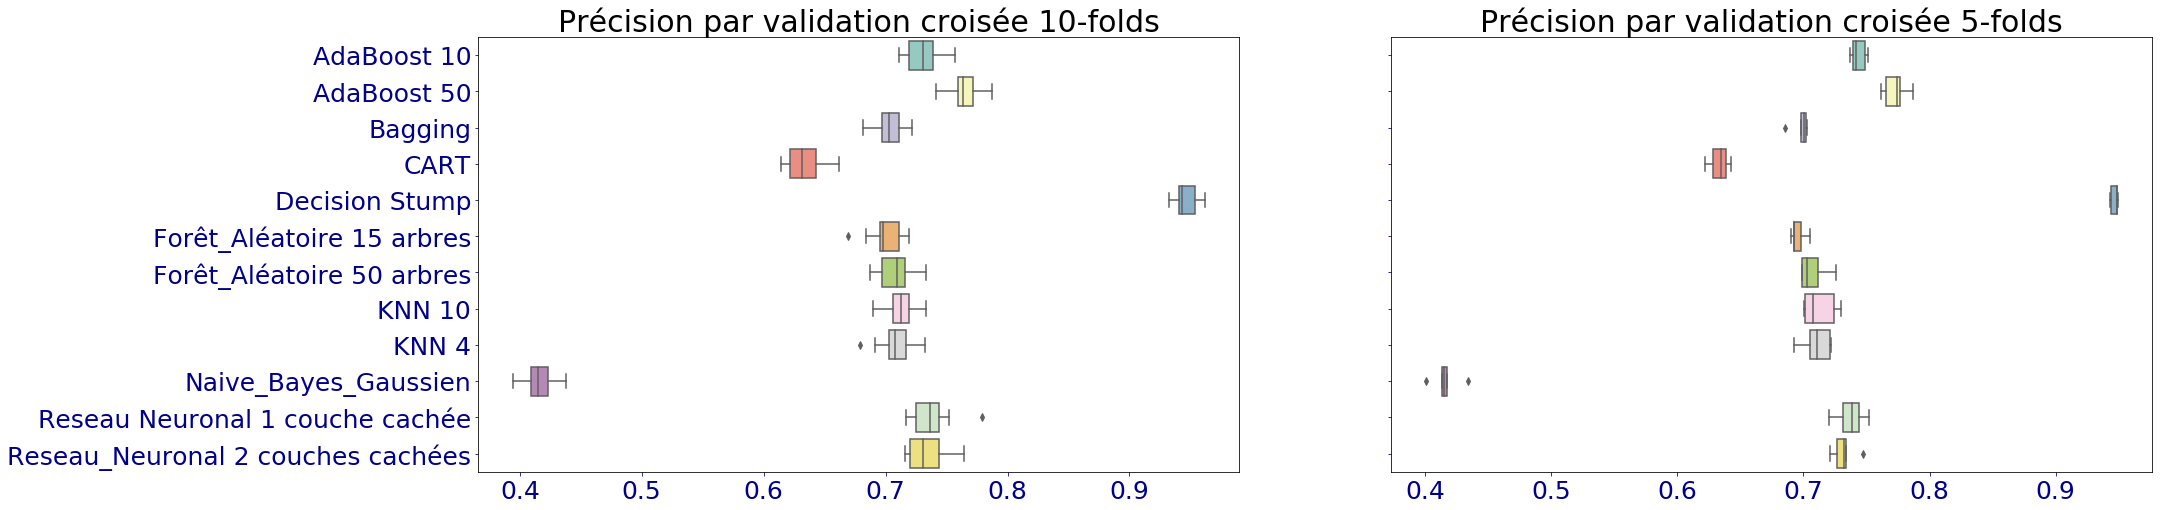

In [11]:
runClassifiers(Liste, X, y, graphe = True)

We try to save all the models:

In [9]:
import dill as pickle

filename = "classicalModels"
pickle.dump(Liste, open(filename, "wb"))

In [8]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
# from id3 import Id3Estimator

Liste = {
'Naive_Bayes_Gaussien': GaussianNB(),  # Naive Bayes classifier http://scikit-learn.org/stable/modules/naive_bayes.html
'CART': DecisionTreeClassifier(), # Classification And Regression Tree (CART) http://scikit-learn.org/stable/modules/tree.html
#'ID3' : id3.Id3Estimator(gain_ratio= True, prune = True),    # Iterative dichotomizer 3 (ID3) https://pypi.python.org/pypi/decision-tree-id3/0.1.2
'Decision Stump' : DecisionTreeClassifier(max_depth=1), # Decision Stump
'Reseau Neuronal 1 couche cachée': MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(20), random_state=1),
'Reseau_Neuronal 2 couches cachées': MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(20, 5), random_state=1), # Réseau de neurones à 2 couches cachées http://scikit-learn.org/stable/modules/neural_networks_supervised.html
'Bagging': BaggingClassifier(base_estimator=None, n_estimators=10, max_samples=1.0, max_features=1.0, bootstrap=True, bootstrap_features=False, oob_score=False, warm_start=False, n_jobs=-1, random_state=None, verbose=0), # Bootstrap Aggregation http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html
'AdaBoost 10': AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), algorithm="SAMME", n_estimators=10),
'AdaBoost 50': AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), algorithm="SAMME", n_estimators=50), # Adaboost http://scikit-learn.org/stable/auto_examples/ensemble/plot_adaboost_twoclass.html
'KNN 1': KNeighborsClassifier(n_neighbors=1, n_jobs = -1),
'KNN 3': KNeighborsClassifier(n_neighbors=3, n_jobs = -1), # K-plus proches voisins http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
'KNN 5': KNeighborsClassifier(n_neighbors=5, n_jobs = -1),
'KNN 7': KNeighborsClassifier(n_neighbors=7, n_jobs = -1),
'Forêt_Aléatoire 15 arbres': RandomForestClassifier(n_estimators=15, n_jobs=-1),
'Forêt_Aléatoire 50 arbres': RandomForestClassifier(n_estimators=50, n_jobs=-1)   # Foret aléatoire http://scikit-learn.org/stable/modules/ensemble.html
}